## ***Failed*** ***try***

In [ ]:
!pip install ultralytics

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.2/107.7 GB disk)


In [ ]:
!pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import glob
from PIL import Image
from ultralytics import YOLO
import urllib.request
from google.colab.patches import cv2_imshow
# import easyocr
# import pytesseract
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Lambda, Reshape, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Permute, TimeDistributed
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive



0: 416x640 1 کل ناحیه پلاک, 192.7ms
Speed: 5.1ms preprocess, 192.7ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


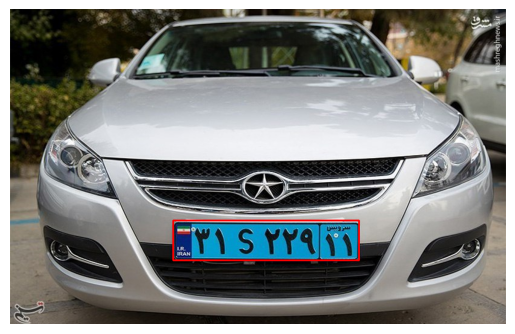

1/1 [==============================] - 2s 2s/step
Real: 123ABC, Predicted: 5
Model Accuracy: 0.00%


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

yolo_model = YOLO("/content/drive/MyDrive/best_model_nano.pt")
ocr_model = load_model("/content/drive/MyDrive/ocr_model_test2.h5")

image_path = "downloaded_image.jpg"
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"{image_path} didn't find")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = yolo_model(image_rgb)

plt.imshow(image_rgb)
plt.axis("off")

for result in results:
    for box in result.boxes:
        x_min, y_min, x_max, y_max = map(int, box.xyxy[0].tolist())
        cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

plt.imshow(image_rgb)
plt.show()

true_labels = ["123ABC", "456XYZ", "789LMN"]
predicted_labels = []

def segment_characters(plate_img):
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    char_images = []
    char_positions = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if h > 20 and w > 10:
            char_img = thresh[y:y+h, x:x+w]
            char_img = cv2.resize(char_img, (32, 32))
            char_images.append(char_img)
            char_positions.append(x)

    if not char_positions or not char_images:
        return []

    sorted_chars = [char for _, char in sorted(zip(char_positions, char_images), key=lambda x: x[0])]
    return sorted_chars

for idx, result in enumerate(results):
    for box in result.boxes:
        x_min, y_min, x_max, y_max = map(int, box.xyxy[0].tolist())
        cropped_plate = image[y_min:y_max, x_min:x_max]

        characters = segment_characters(cropped_plate)

        predicted_text = ""
        for char in characters:
            char = char.astype("float32") / 255.0
            char = np.expand_dims(char, axis=-1)
            char = np.expand_dims(char, axis=0)

            prediction = ocr_model.predict(char)
            predicted_char = str(np.argmax(prediction))
            predicted_text += predicted_char

        predicted_labels.append(predicted_text)
        print(f"Real: {true_labels[idx]}, Predicted: {predicted_text}")

min_length = min(len(true_labels), len(predicted_labels))
correct = sum([1 for i in range(min_length) if true_labels[i] == predicted_labels[i]])
accuracy = correct / min_length if min_length > 0 else 0

print(f"Model Accuracy: {accuracy * 100:.2f}%")